## Importing libs

In [0]:
COLAB = True # NOTE change me :D

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [4]:
if COLAB:
  try:
    # Colab only
    %tensorflow_version 2.x
  except Exception:
      pass

TensorFlow 2.x selected.


In [5]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [7]:
strftime('%X')

'13:12:35'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [8]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

ls: cannot access '../fashion-mnist-dataset/': No such file or directory


In [0]:
if not COLAB:
  PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

  # the datasets have the label on the first column and the image pixels on the following 784
  train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
  test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [10]:
if COLAB:
  # NOTE run me on Colab instead
  fashion_mnist = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  train_images = train_images.reshape((60000, -1))
  test_images = test_images.reshape((10000, -1))

  train_dataset_csv = np.concatenate((train_labels.reshape(60000, 1), train_images), axis=1)
  test_dataset_csv = np.concatenate((test_labels.reshape(10000, 1), test_images), axis=1)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [0]:
if not COLAB:
  ys_train = train_dataset["label"].values
  ys_val   = validation_dataset["label"].values
  ys_test  = test_dataset["label"].values

  print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
  print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
  print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

In [15]:
if COLAB:
  # NOTE run me on Colab instead
  ys_train = train_dataset[:, 0]
  ys_val   = validation_dataset[:, 0]
  ys_test  = test_dataset[:, 0]

  print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
  print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
  print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [0]:
if not COLAB:
  xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
  xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
  xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

  print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
  print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
  print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

In [17]:
if COLAB:
  # NOTE run me on Colab instead
  xs_train = train_dataset[:, 1:]
  xs_val   = validation_dataset[:, 1:]
  xs_test  = test_dataset[:, 1:]

  print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
  print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
  print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [19]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4772 (0.10%)  1228 (0.10%)  1000 (0.10%)
Trouser:      4793 (0.10%)  1207 (0.10%)  1000 (0.10%)
Pullover:     4776 (0.10%)  1224 (0.10%)  1000 (0.10%)
Dress:        4794 (0.10%)  1206 (0.10%)  1000 (0.10%)
Coat:         4804 (0.10%)  1196 (0.10%)  1000 (0.10%)
Sandal:       4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Shirt:        4824 (0.10%)  1176 (0.10%)  1000 (0.10%)
Sneaker:      4806 (0.10%)  1194 (0.10%)  1000 (0.10%)
Bag:          4797 (0.10%)  1203 (0.10%)  1000 (0.10%)
Ankle boot:   4814 (0.10%)  1186 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val = xs_val.astype('float32') / 255.0
xs_test = xs_test.astype('float32') / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [21]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2857, stddev= 0.3527
X_train:  mean= -0.0000, stddev= 1.0000


In [22]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2875, stddev= 0.3541
X_val:  mean=  0.0053, stddev= 1.0039


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [24]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [25]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=64, batch_size=1024, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience))
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [36]:
strftime('%X')

'13:12:59'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 54us/sample - loss: 0.6687 - accuracy: 0.7700 - val_loss: 0.4637 - val_accuracy: 0.8438
Epoch 2/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.4171 - accuracy: 0.8561 - val_loss: 0.4122 - val_accuracy: 0.8602
Epoch 3/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3746 - accuracy: 0.8700 - val_loss: 0.3898 - val_accuracy: 0.8665
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3442 - accuracy: 0.8790 - val_loss: 0.3767 - val_accuracy: 0.8717
Epoch 5/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3250 - accuracy: 0.8863 - val_loss: 0.3588 - val_accuracy: 0.8798
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3093 - accuracy: 0.8914 - val_loss: 0.3518 - val_accuracy: 0.8788
Epoch 7/64
48000/48000 [===========

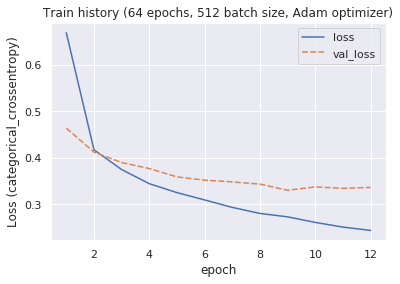

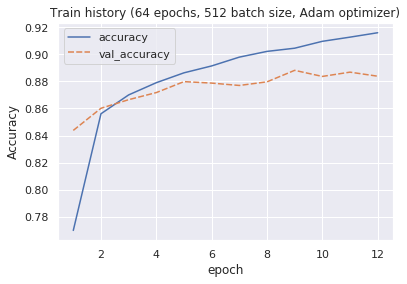

In [37]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val, 
                            n_epochs=64, batch_size=512)

In [38]:
strftime('%X')

'13:13:09'

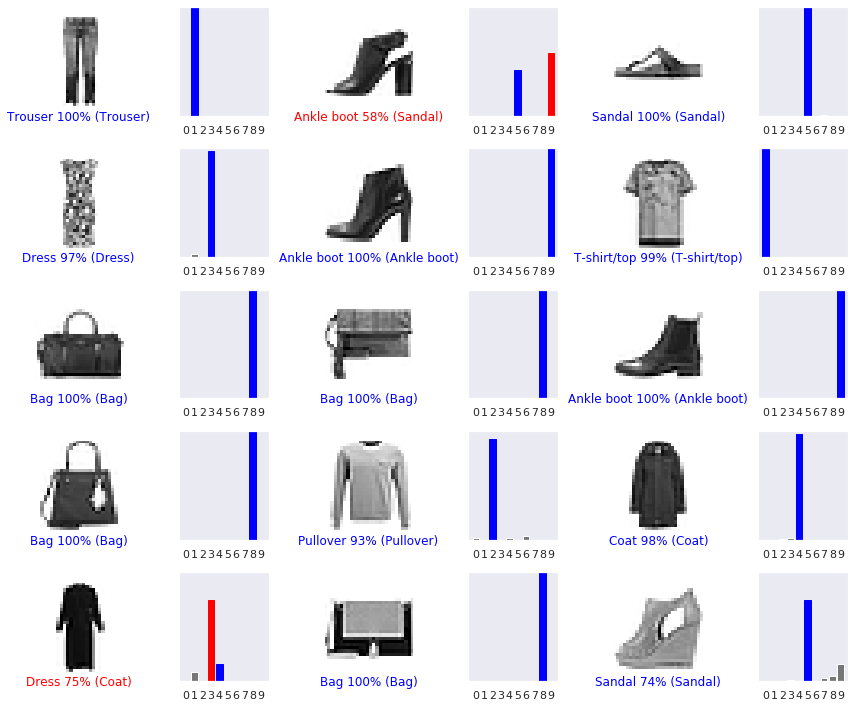

In [39]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

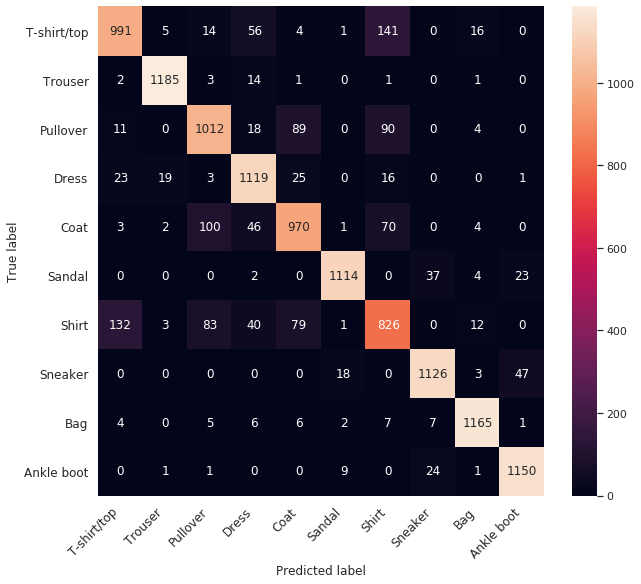

In [40]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [43]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [44]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [45]:
strftime('%X')

'13:13:15'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 132us/sample - loss: 0.7278 - accuracy: 0.7676 - val_loss: 0.4764 - val_accuracy: 0.8420
Epoch 2/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.4260 - accuracy: 0.8570 - val_loss: 0.3965 - val_accuracy: 0.8698
Epoch 3/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3760 - accuracy: 0.8763 - val_loss: 0.3885 - val_accuracy: 0.8723
Epoch 4/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.3490 - accuracy: 0.8871 - val_loss: 0.3427 - val_accuracy: 0.8901
Epoch 5/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.3288 - accuracy: 0.8937 - val_loss: 0.3420 - val_accuracy: 0.8863
Epoch 6/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3132 - accuracy: 0.8987 - val_loss: 0.3370 - val_accuracy: 0.8848
Epoch 7/64
48000/48000 [==========

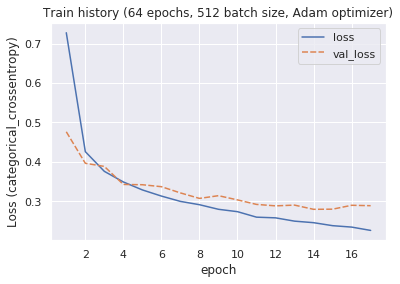

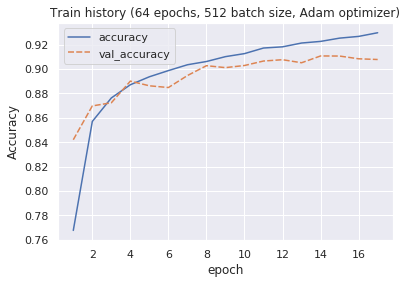

In [46]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val, 
                                      n_epochs=64, batch_size=512)

In [47]:
strftime('%X')

'13:14:02'

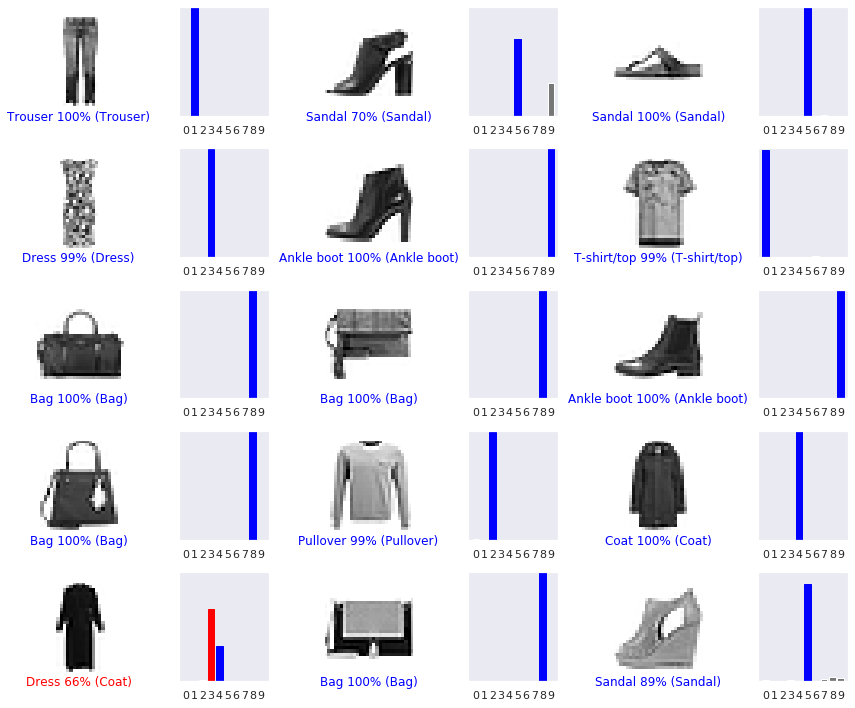

In [48]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

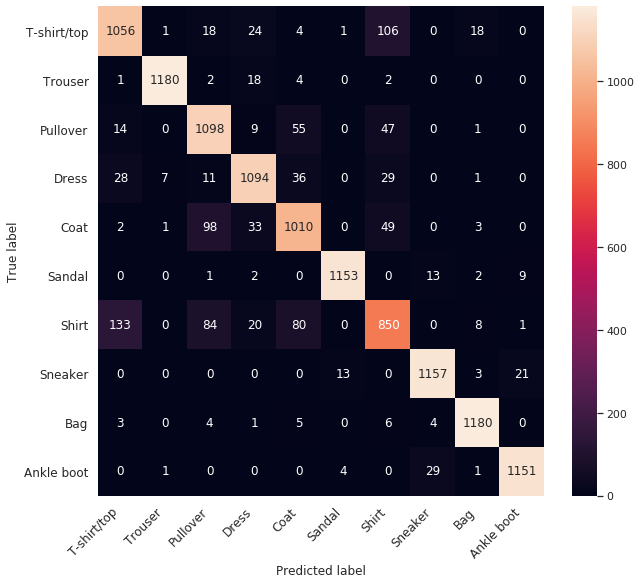

In [49]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

### 1.3. CNN with batch normalization

In [0]:
from tensorflow.keras.layers import Dropout, BatchNormalization, ReLU

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_v2_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1)),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_v2_baseline")

In [0]:
conv_v2_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [53]:
conv_v2_model.summary()

Model: "CNN_v2_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)    

In [54]:
conv_v2_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [55]:
strftime('%X')

'13:14:08'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 4s 85us/sample - loss: 0.5578 - accuracy: 0.8141 - val_loss: 1.3958 - val_accuracy: 0.6375
Epoch 2/64
48000/48000 [==============================] - 3s 64us/sample - loss: 0.3375 - accuracy: 0.8879 - val_loss: 1.0689 - val_accuracy: 0.6983
Epoch 3/64
48000/48000 [==============================] - 3s 64us/sample - loss: 0.2864 - accuracy: 0.9048 - val_loss: 0.7022 - val_accuracy: 0.7862
Epoch 4/64
48000/48000 [==============================] - 3s 63us/sample - loss: 0.2592 - accuracy: 0.9148 - val_loss: 0.4357 - val_accuracy: 0.8701
Epoch 5/64
48000/48000 [==============================] - 3s 63us/sample - loss: 0.2362 - accuracy: 0.9226 - val_loss: 0.3338 - val_accuracy: 0.8851
Epoch 6/64
48000/48000 [==============================] - 3s 64us/sample - loss: 0.2196 - accuracy: 0.9279 - val_loss: 0.2960 - val_accuracy: 0.9006
Epoch 7/64
48000/48000 [===========

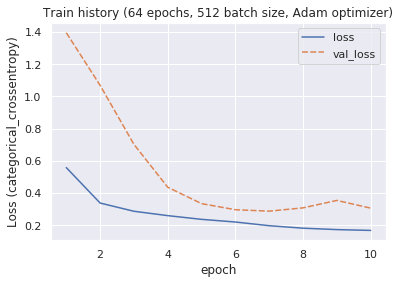

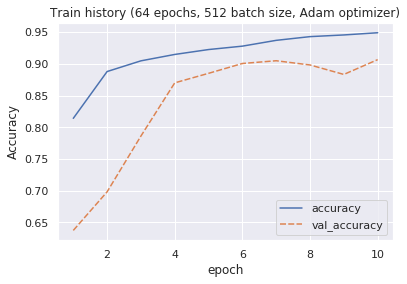

In [56]:
conv_v2_history, best_conv_v2_model = train(conv_v2_model, X_train, Y_train, X_val, Y_val, 
                                            n_epochs=64, batch_size=512)

In [57]:
strftime('%X')

'13:14:42'

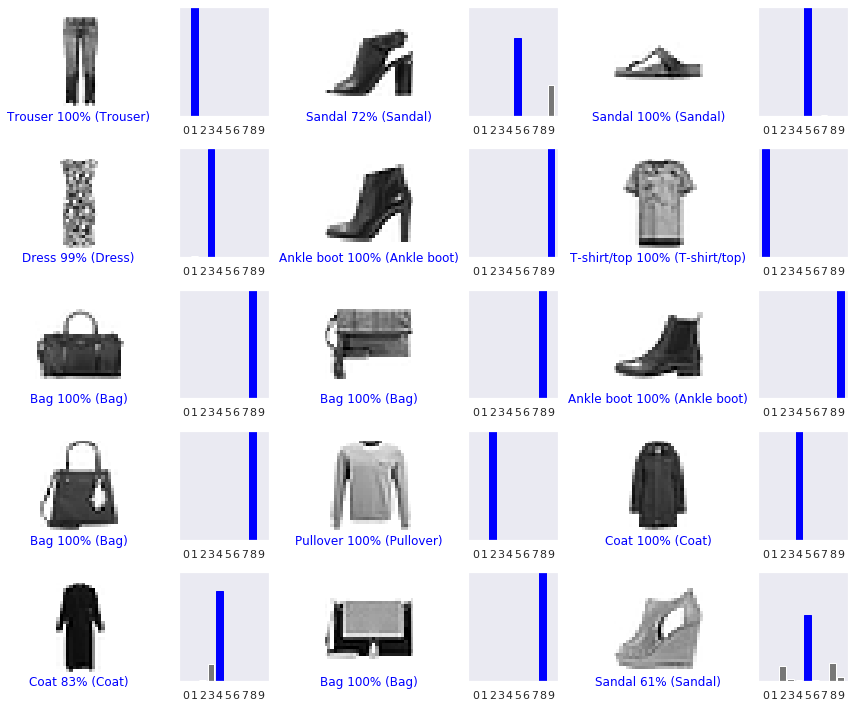

In [58]:
Y_val_conv_v2_pred = best_conv_v2_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_v2_pred)

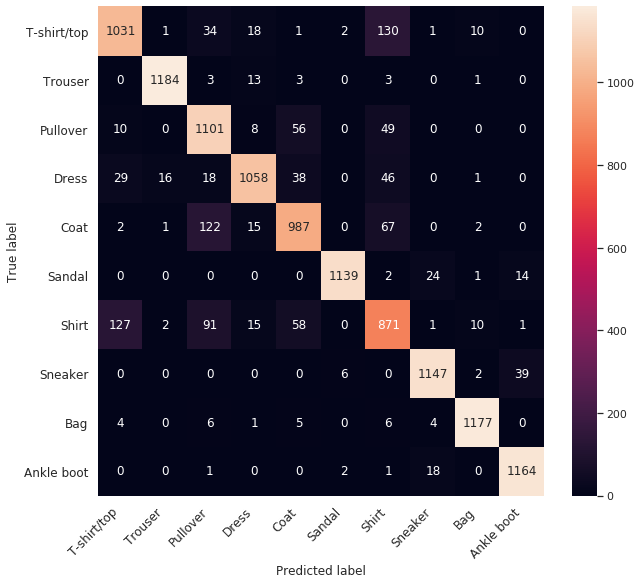

In [59]:
print_cm(ys_val, np.argmax(Y_val_conv_v2_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [62]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.03 | mean: -0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: uint8   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.507 | std: 2.871


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [65]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.990027666091919 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 29us/sample - loss: 0.7800 - accuracy: 0.7540 - val_loss: 0.4454 - val_accuracy: 0.8500
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3840 - accuracy: 0.8721 - val_loss: 0.3904 - val_accuracy: 0.8653
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3272 - accuracy: 0.8903 - val_loss: 0.3701 - val_accuracy: 0.8715
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2919 - accuracy: 0.9042 - val_loss: 0.3609 - val_accuracy: 0.8736
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2640 - accuracy: 0.9137 - val_loss: 0.3576 - val_accuracy: 0.8767
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2397 - accuracy: 0.9234 - val_loss: 0.3532 - val_accuracy: 0.8797
Epoch 7/64
48000/48000 [===========

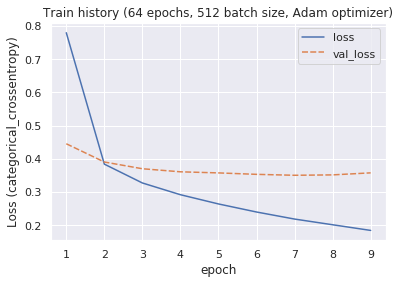

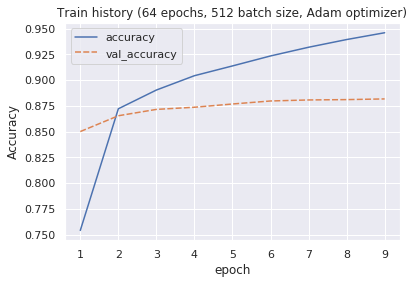

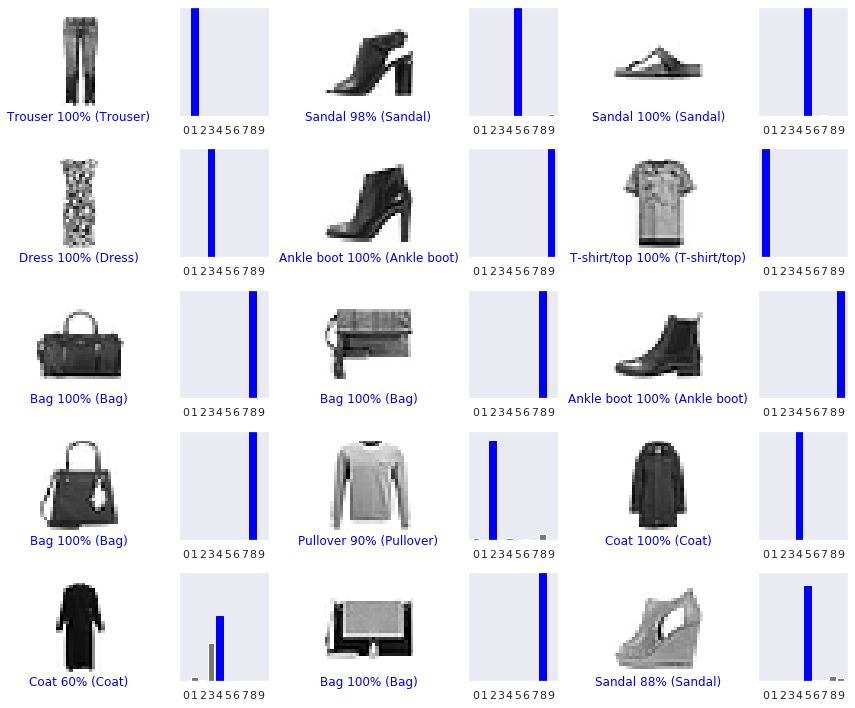

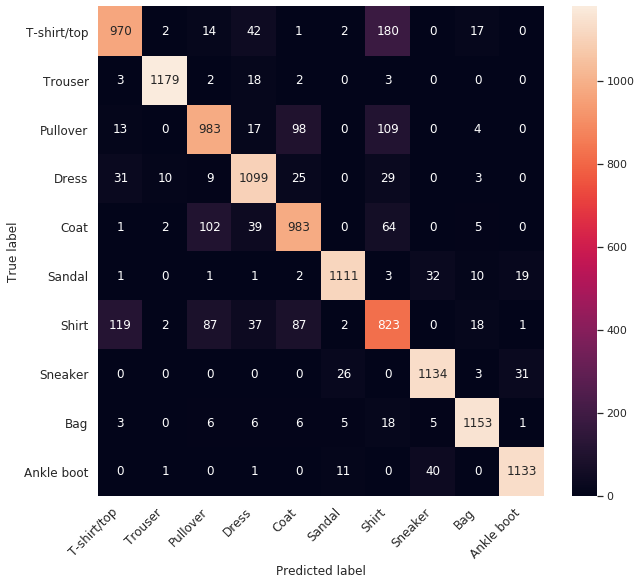

In [66]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [67]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9500905871391296 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8337 - accuracy: 0.7314 - val_loss: 0.4743 - val_accuracy: 0.8408
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4170 - accuracy: 0.8584 - val_loss: 0.4068 - val_accuracy: 0.8638
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3629 - accuracy: 0.8771 - val_loss: 0.3817 - val_accuracy: 0.8706
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3318 - accuracy: 0.8878 - val_loss: 0.3623 - val_accuracy: 0.8758
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3071 - accuracy: 0.8963 - val_loss: 0.3531 - val_accuracy: 0.8817
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2883 - accuracy: 0.9036 - val_loss: 0.3487 - val_accuracy: 0.8817
Epoch 7/64
48000/48000 [===========

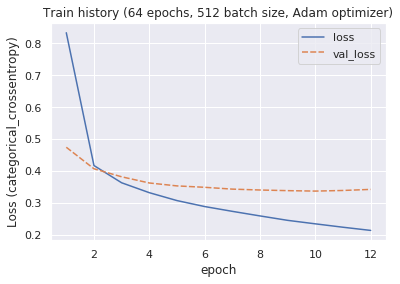

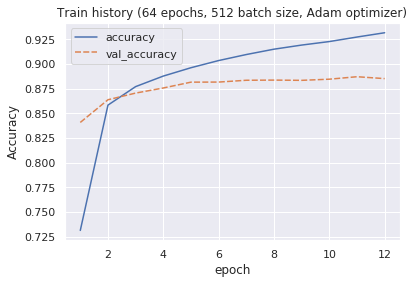

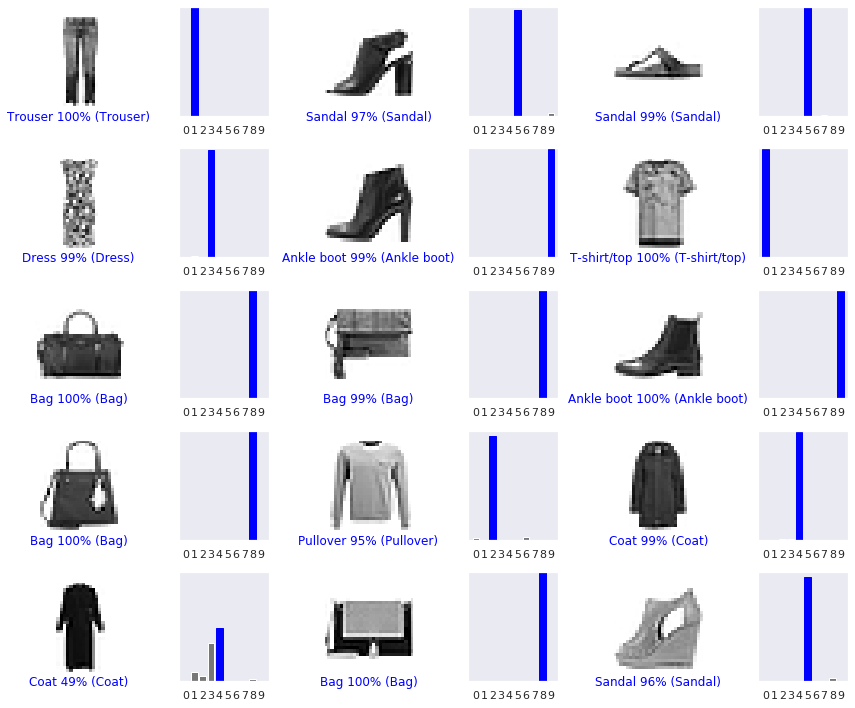

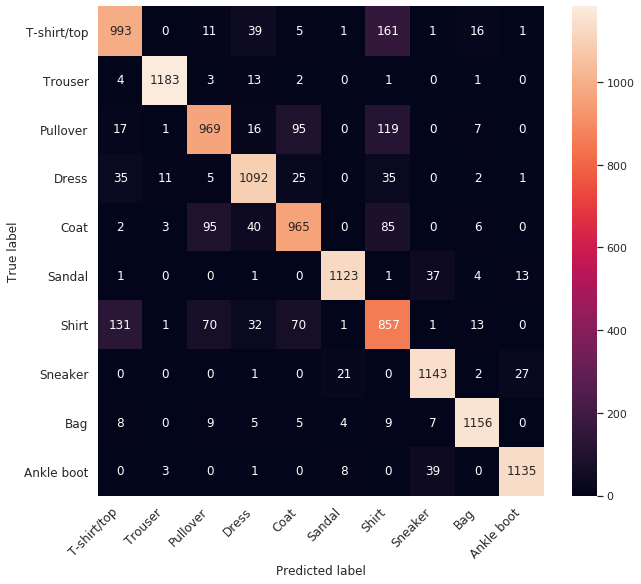

In [68]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [69]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006666541099548 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.8250 - accuracy: 0.7300 - val_loss: 0.4841 - val_accuracy: 0.8355
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4341 - accuracy: 0.8526 - val_loss: 0.4227 - val_accuracy: 0.8529
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3844 - accuracy: 0.8694 - val_loss: 0.3953 - val_accuracy: 0.8625
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3569 - accuracy: 0.8781 - val_loss: 0.3753 - val_accuracy: 0.8707
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3366 - accuracy: 0.8845 - val_loss: 0.3608 - val_accuracy: 0.8742
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3211 - accuracy: 0.8892 - val_loss: 0.3532 - val_accuracy: 0.8810
Epoch 7/64
48000/48000 [===========

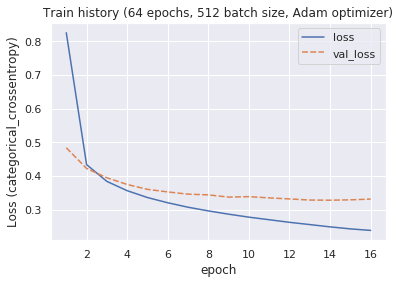

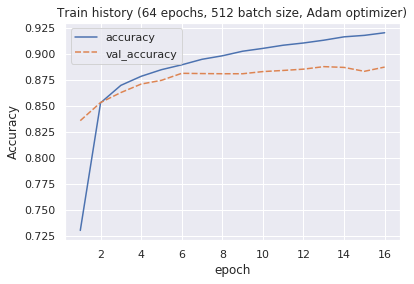

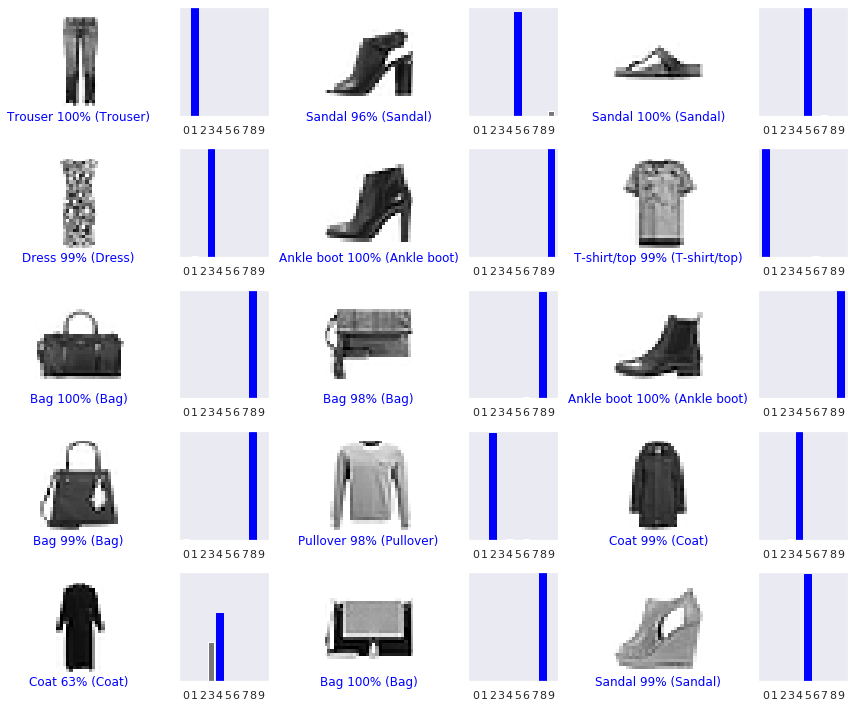

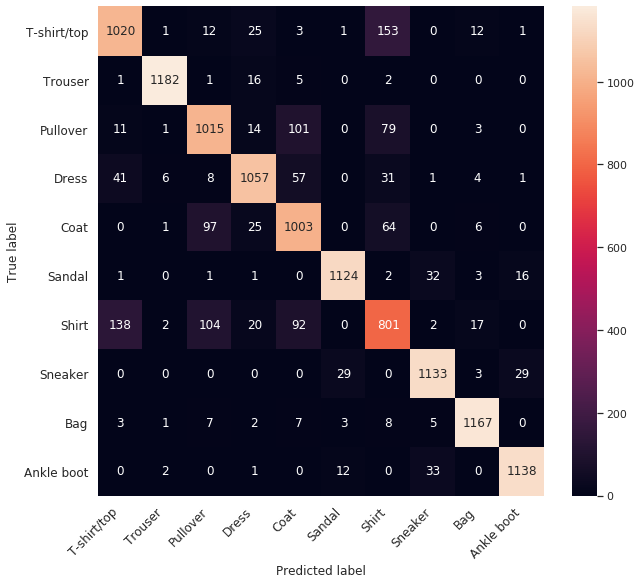

In [70]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [73]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8499  |  0.8070  |  0.8279
Class 1 (Trouser):       0.9753  |  0.9818  |  0.9785
Class 2 (Pullover):      0.8288  |  0.8268  |  0.8278
Class 3 (Dress):         0.8601  |  0.9279  |  0.8927
Class 4 (Coat):          0.8262  |  0.8110  |  0.8186
Class 5 (Sandal):        0.9721  |  0.9441  |  0.9579
Class 6 (Shirt):         0.7176  |  0.7024  |  0.7099
Class 7 (Sneaker):       0.9430  |  0.9430  |  0.9430
Class 8 (Bag):           0.9628  |  0.9684  |  0.9656
Class 9 (Ankle boot):    0.9411  |  0.9696  |  0.9551

Combined F1 score:  0.8791
Combined Precision: 0.8799
Combined Recall:    0.8783


In [74]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8537  |  0.8599  |  0.8568
Class 1 (Trouser):       0.9916  |  0.9776  |  0.9846
Class 2 (Pullover):      0.8343  |  0.8971  |  0.8646
Class 3 (Dress):         0.9109  |  0.9071  |  0.9090
Class 4 (Coat):          0.8459  |  0.8445  |  0.8452
Class 5 (Sandal):        0.9846  |  0.9771  |  0.9809
Class 6 (Shirt):         0.7805  |  0.7228  |  0.7506
Class 7 (Sneaker):       0.9618  |  0.9690  |  0.9654
Class 8 (Bag):           0.9696  |  0.9809  |  0.9752
Class 9 (Ankle boot):    0.9738  |  0.9705  |  0.9721

Combined F1 score:  0.9038
Combined Precision: 0.9047
Combined Recall:    0.9029


In [75]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8501  |  0.7899  |  0.8189
Class 1 (Trouser):       0.9858  |  0.9768  |  0.9813
Class 2 (Pullover):      0.8164  |  0.8031  |  0.8097
Class 3 (Dress):         0.8722  |  0.9113  |  0.8913
Class 4 (Coat):          0.8164  |  0.8219  |  0.8192
Class 5 (Sandal):        0.9602  |  0.9415  |  0.9508
Class 6 (Shirt):         0.6697  |  0.6998  |  0.6844
Class 7 (Sneaker):       0.9364  |  0.9497  |  0.9430
Class 8 (Bag):           0.9505  |  0.9584  |  0.9545
Class 9 (Ankle boot):    0.9561  |  0.9553  |  0.9557

Combined F1 score:  0.8707
Combined Precision: 0.8705
Combined Recall:    0.8709


In [76]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8338  |  0.8086  |  0.8210
Class 1 (Trouser):       0.9842  |  0.9801  |  0.9822
Class 2 (Pullover):      0.8339  |  0.7917  |  0.8122
Class 3 (Dress):         0.8806  |  0.9055  |  0.8929
Class 4 (Coat):          0.8269  |  0.8069  |  0.8168
Class 5 (Sandal):        0.9698  |  0.9517  |  0.9607
Class 6 (Shirt):         0.6759  |  0.7287  |  0.7013
Class 7 (Sneaker):       0.9308  |  0.9573  |  0.9438
Class 8 (Bag):           0.9577  |  0.9609  |  0.9593
Class 9 (Ankle boot):    0.9643  |  0.9570  |  0.9606

Combined F1 score:  0.8755
Combined Precision: 0.8752
Combined Recall:    0.8759


In [77]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8395  |  0.8306  |  0.8350
Class 1 (Trouser):       0.9883  |  0.9793  |  0.9838
Class 2 (Pullover):      0.8153  |  0.8292  |  0.8222
Class 3 (Dress):         0.9104  |  0.8765  |  0.8931
Class 4 (Coat):          0.7910  |  0.8386  |  0.8141
Class 5 (Sandal):        0.9615  |  0.9525  |  0.9570
Class 6 (Shirt):         0.7026  |  0.6811  |  0.6917
Class 7 (Sneaker):       0.9395  |  0.9489  |  0.9442
Class 8 (Bag):           0.9605  |  0.9701  |  0.9653
Class 9 (Ankle boot):    0.9603  |  0.9595  |  0.9599

Combined F1 score:  0.8767
Combined Precision: 0.8770
Combined Recall:    0.8765


### 2.4. <90% explained variance

**80% explained variance**

In [78]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8010118007659912 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 29us/sample - loss: 0.8698 - accuracy: 0.7156 - val_loss: 0.5482 - val_accuracy: 0.8123
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5007 - accuracy: 0.8260 - val_loss: 0.4823 - val_accuracy: 0.8394
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4529 - accuracy: 0.8431 - val_loss: 0.4519 - val_accuracy: 0.8470
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4276 - accuracy: 0.8512 - val_loss: 0.4366 - val_accuracy: 0.8533
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4100 - accuracy: 0.8576 - val_loss: 0.4198 - val_accuracy: 0.8583
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3977 - accuracy: 0.8613 - val_loss: 0.4117 - val_accuracy: 0.8590
Epoch 7/64
48000/48000 [===========

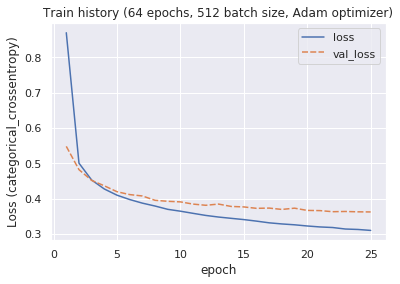

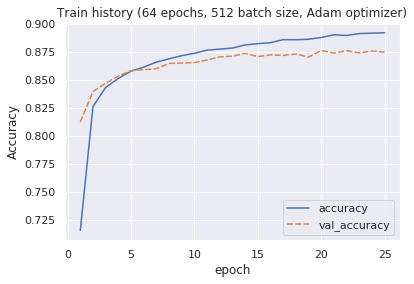

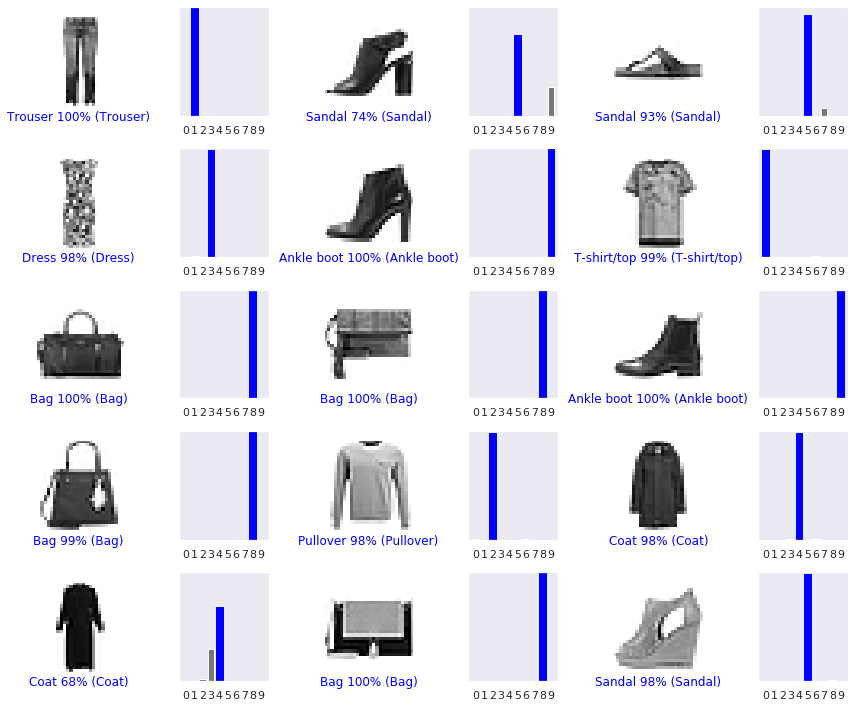

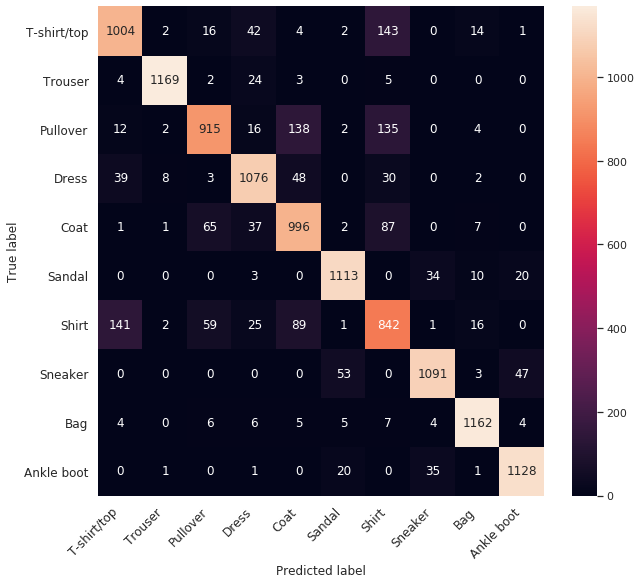

In [79]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [80]:
# 80% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8332  |  0.8176  |  0.8253
Class 1 (Trouser):       0.9865  |  0.9685  |  0.9774
Class 2 (Pullover):      0.8583  |  0.7475  |  0.7991
Class 3 (Dress):         0.8748  |  0.8922  |  0.8834
Class 4 (Coat):          0.7763  |  0.8328  |  0.8035
Class 5 (Sandal):        0.9290  |  0.9432  |  0.9361
Class 6 (Shirt):         0.6741  |  0.7160  |  0.6944
Class 7 (Sneaker):       0.9365  |  0.9137  |  0.9250
Class 8 (Bag):           0.9532  |  0.9659  |  0.9595
Class 9 (Ankle boot):    0.9400  |  0.9511  |  0.9455

Combined F1 score:  0.8657
Combined Precision: 0.8658
Combined Recall:    0.8656


**60% explained variance**

In [81]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6160919666290283 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 21us/sample - loss: 1.0669 - accuracy: 0.6362 - val_loss: 0.7852 - val_accuracy: 0.7163
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7540 - accuracy: 0.7186 - val_loss: 0.7335 - val_accuracy: 0.7281
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7221 - accuracy: 0.7274 - val_loss: 0.7119 - val_accuracy: 0.7333
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7045 - accuracy: 0.7312 - val_loss: 0.7074 - val_accuracy: 0.7319
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6937 - accuracy: 0.7370 - val_loss: 0.6929 - val_accuracy: 0.7379
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6861 - accuracy: 0.7387 - val_loss: 0.6846 - val_accuracy: 0.7428
Epoch 7/64
48000/48000 [===========

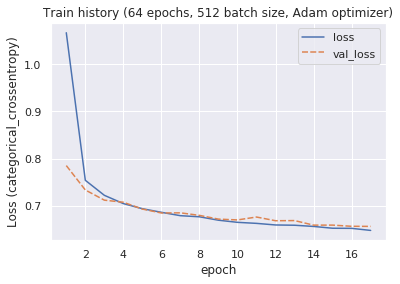

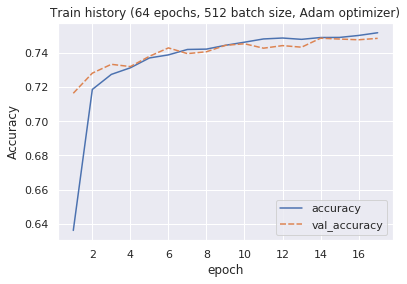

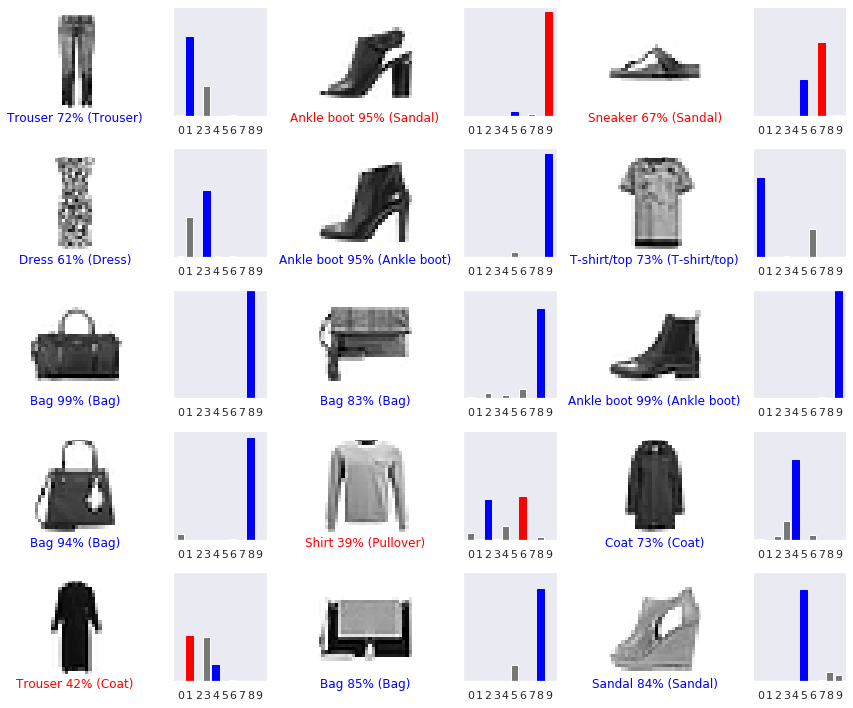

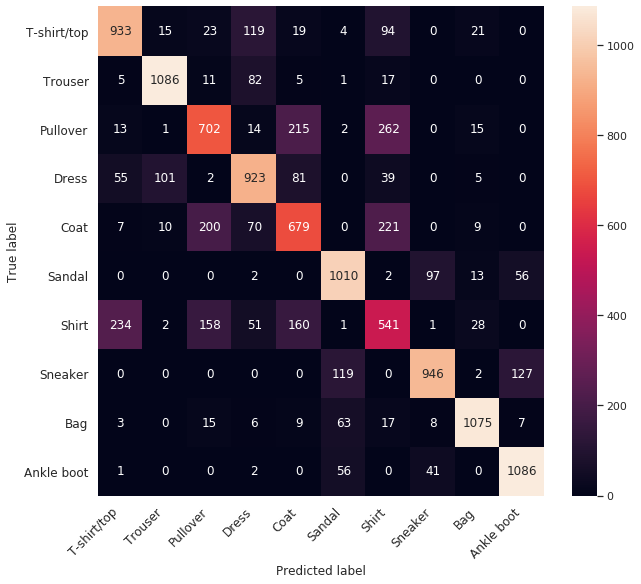

In [82]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [83]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7458  |  0.7598  |  0.7527
Class 1 (Trouser):       0.8938  |  0.8998  |  0.8968
Class 2 (Pullover):      0.6319  |  0.5735  |  0.6013
Class 3 (Dress):         0.7273  |  0.7653  |  0.7459
Class 4 (Coat):          0.5813  |  0.5677  |  0.5745
Class 5 (Sandal):        0.8041  |  0.8559  |  0.8292
Class 6 (Shirt):         0.4535  |  0.4600  |  0.4567
Class 7 (Sneaker):       0.8655  |  0.7923  |  0.8273
Class 8 (Bag):           0.9204  |  0.8936  |  0.9068
Class 9 (Ankle boot):    0.8511  |  0.9157  |  0.8822

Combined F1 score:  0.7128
Combined Precision: 0.7141
Combined Recall:    0.7115


### 2.5. Plot the first 3 principal components

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [86]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2902 (cumulative sum: 0.29)
PC 2: 0.1773 (cumulative sum: 0.47)
PC 3: 0.0604 (cumulative sum: 0.53)


In [0]:
if not COLAB:
  plt.figure(figsize=(16, 10))
  sns.scatterplot(
      x=pca_3pc_result[..., 0], # PC 1
      y=pca_3pc_result[..., 1], # PC 2
      hue="label",
      palette=sns.color_palette("hls", 10),
      data=train_dataset,
      legend="full",
      alpha=0.3
  )

In [0]:
from mpl_toolkits.mplot3d import Axes3D

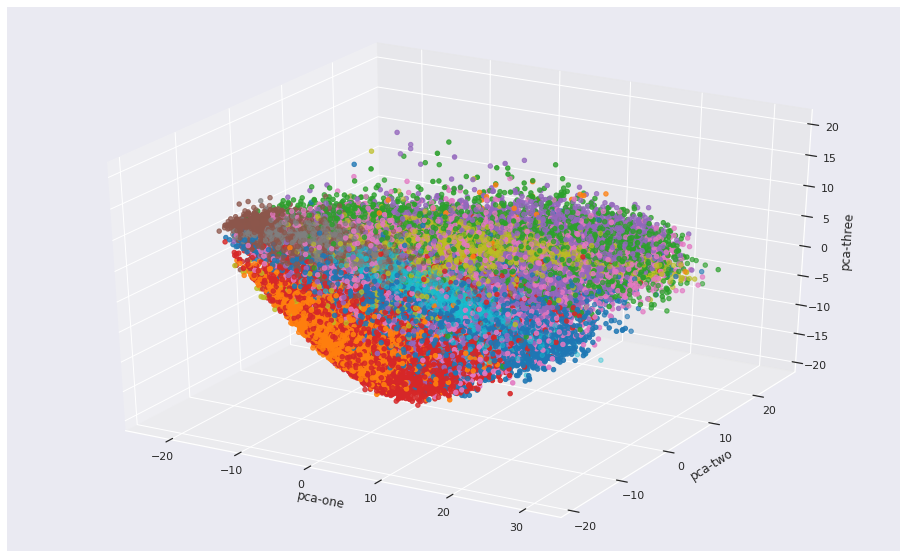

In [89]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("Autoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("Encoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("Decoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=64,
                    batch_size=512,
                    shuffle=True,
                    callbacks=callbacks)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_sample(encoder, decoder):
    # encode and decode some digits
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10 # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    ###

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val, 
                                      n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [95]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)

Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_21 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None
Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 84)                65940 

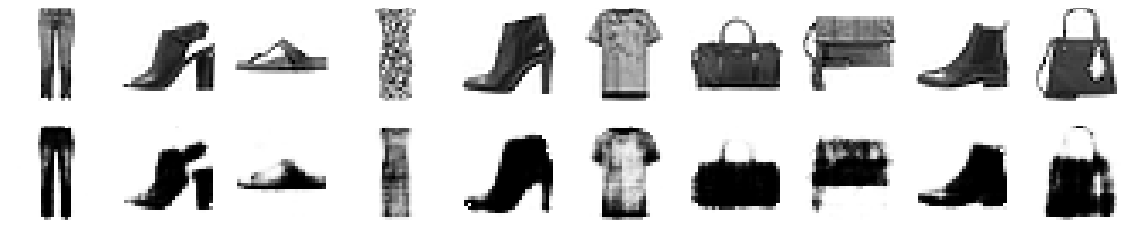

In [96]:
show_autoencoder_sample(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.9122 - accuracy: 0.7006 - val_loss: 0.5270 - val_accuracy: 0.8190
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4714 - accuracy: 0.8371 - val_loss: 0.4539 - val_accuracy: 0.8423
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4227 - accuracy: 0.8549 - val_loss: 0.4308 - val_accuracy: 0.8515
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3950 - accuracy: 0.8639 - val_loss: 0.4089 - val_accuracy: 0.8587
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3753 - accuracy: 0.8720 - val_loss: 0.3970 - val_accuracy: 0.8621
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3594 - accuracy: 0.8767 - val_loss: 0.3852 - val_accuracy: 0.8676
Epoch 7/64
48000/48000 [===========

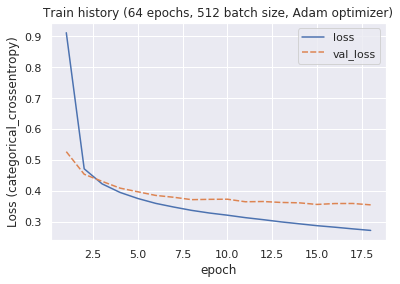

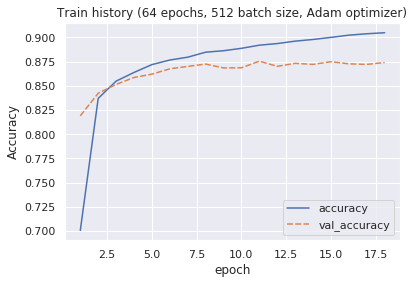

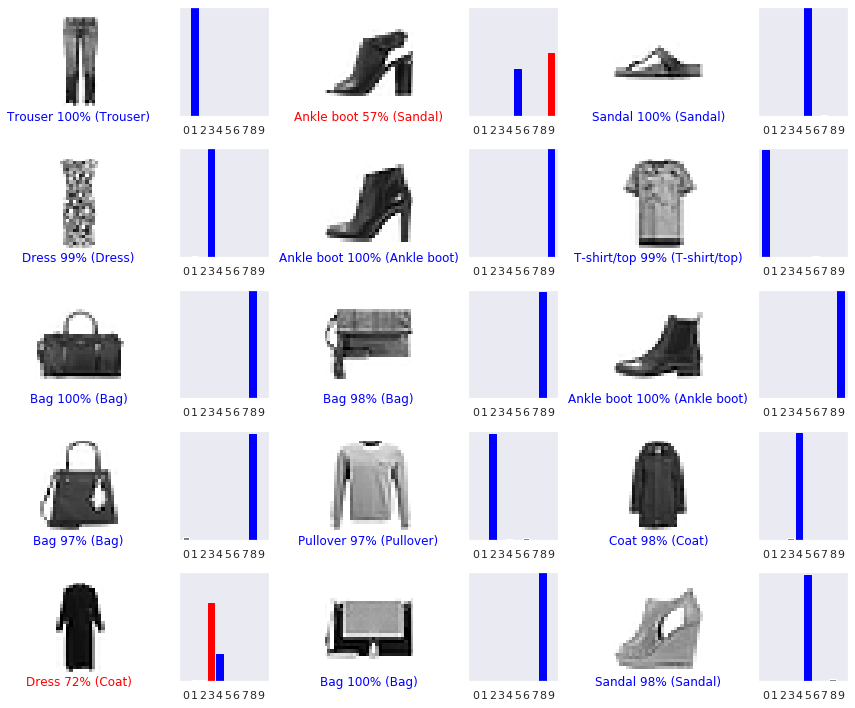

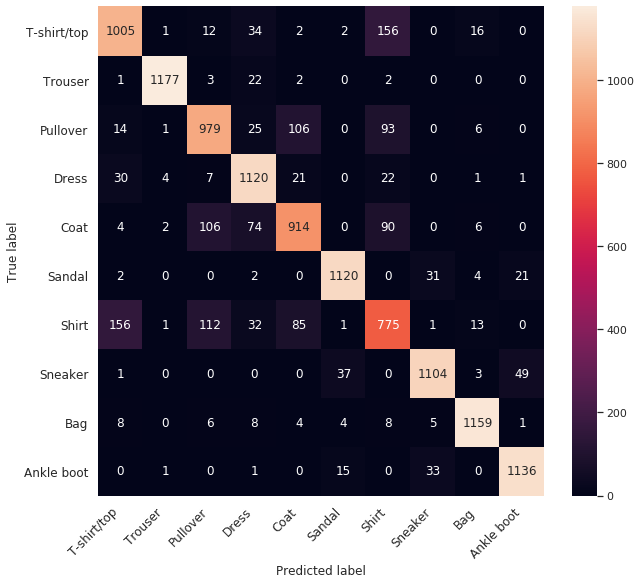

In [97]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [98]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8231  |  0.8184  |  0.8207
Class 1 (Trouser):       0.9916  |  0.9751  |  0.9833
Class 2 (Pullover):      0.7992  |  0.7998  |  0.7995
Class 3 (Dress):         0.8498  |  0.9287  |  0.8875
Class 4 (Coat):          0.8060  |  0.7642  |  0.7845
Class 5 (Sandal):        0.9500  |  0.9492  |  0.9496
Class 6 (Shirt):         0.6763  |  0.6590  |  0.6675
Class 7 (Sneaker):       0.9404  |  0.9246  |  0.9324
Class 8 (Bag):           0.9594  |  0.9634  |  0.9614
Class 9 (Ankle boot):    0.9404  |  0.9578  |  0.9490

Combined F1 score:  0.8617
Combined Precision: 0.8626
Combined Recall:    0.8608


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [100]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)

Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_25 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_26 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None
Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_25 (Dense)             (None, 24)                18840 

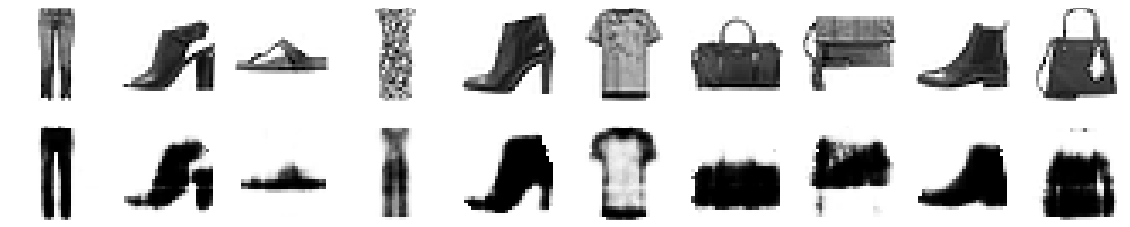

In [101]:
show_autoencoder_sample(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 1.0859 - accuracy: 0.6748 - val_loss: 0.5790 - val_accuracy: 0.7974
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5295 - accuracy: 0.8163 - val_loss: 0.5108 - val_accuracy: 0.8242
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4802 - accuracy: 0.8328 - val_loss: 0.4864 - val_accuracy: 0.8320
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4560 - accuracy: 0.8408 - val_loss: 0.4605 - val_accuracy: 0.8397
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4393 - accuracy: 0.8446 - val_loss: 0.4504 - val_accuracy: 0.8418
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4261 - accuracy: 0.8507 - val_loss: 0.4422 - val_accuracy: 0.8430
Epoch 7/64
48000/48000 [===========

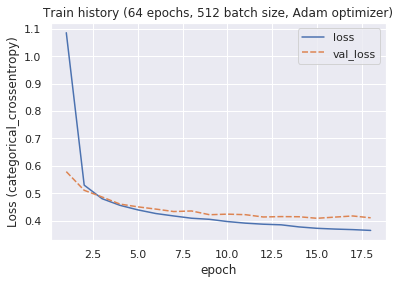

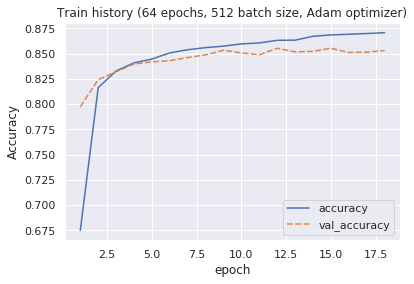

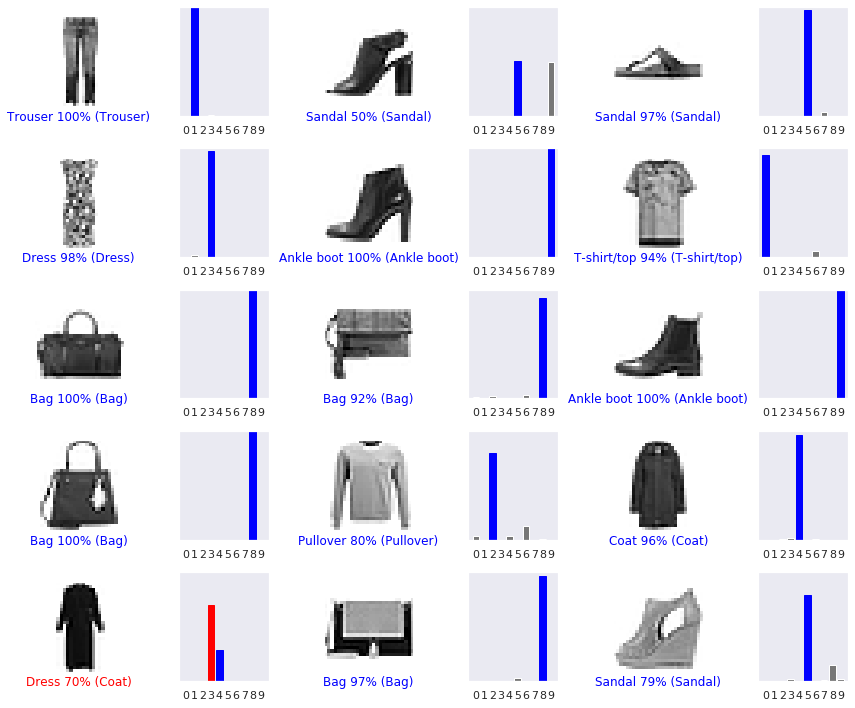

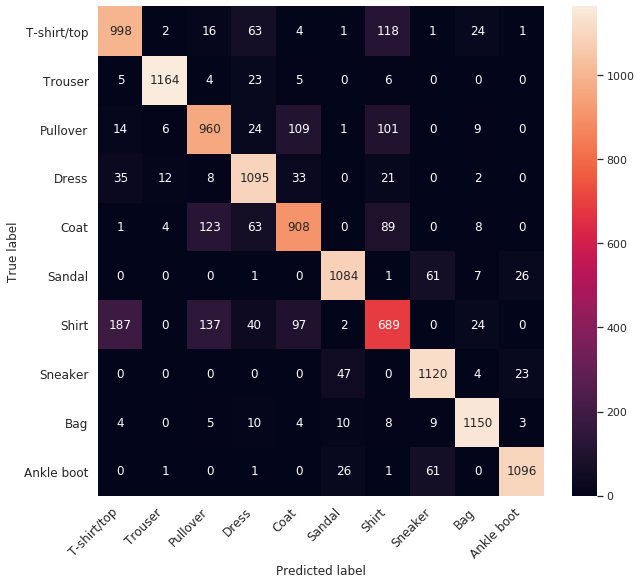

In [102]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [103]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8023  |  0.8127  |  0.8074
Class 1 (Trouser):       0.9790  |  0.9644  |  0.9716
Class 2 (Pullover):      0.7662  |  0.7843  |  0.7751
Class 3 (Dress):         0.8295  |  0.9080  |  0.8670
Class 4 (Coat):          0.7828  |  0.7592  |  0.7708
Class 5 (Sandal):        0.9257  |  0.9186  |  0.9222
Class 6 (Shirt):         0.6663  |  0.5859  |  0.6235
Class 7 (Sneaker):       0.8946  |  0.9380  |  0.9158
Class 8 (Bag):           0.9365  |  0.9559  |  0.9461
Class 9 (Ankle boot):    0.9539  |  0.9241  |  0.9388

Combined F1 score:  0.8396
Combined Precision: 0.8424
Combined Recall:    0.8368


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import adjusted_rand_score

In [0]:
# this fails, when the correspondence is not perfect, like in our case :(
# what I think would work is creating a confusion matrix, then sort the rows trying to maximize the diagonal sum
def map_cluster_predictions(true_pred, pred, class_number): 
    mapped = 0
    res = [-1 for _ in range(class_number)]
    for i in range(len(true_pred)):
        if res[ true_pred[i] ] == -1:
            res[ true_pred[i] ] = pred[i]
            mapped += 1
            if mapped >= class_number:
                break
    return res

In [142]:
a = [0,0,0,1,2]
b = [0,1,0,0,2]
map_cluster_predictions(a,b,3)

[0, 0, 2]

In [0]:
def show_clusters(clusters, data):
    print("Clusters:",set(clusters.labels_))

    not_onehot = Y_val.argmax(axis=1)

    print("Score":,adjusted_rand_score(not_onehot, clusters.labels_))

    print( "Right:", np.count_nonzero((clusters.labels_ - not_onehot) == 0) )
    print( "Wrong:", np.count_nonzero((clusters.labels_ - not_onehot) != 0) )

    labels = clusters.labels_.astype(float)
    try:
      centroids = clusters.cluster_centers_
    except:
      centroids = None

    xs = data[..., 0]
    ys = data[..., 1]

    # plt.figure()
    plt.scatter(
        x=xs, 
        y=ys,
        c=labels, 
        s=50, 
        alpha=0.8,
        cmap="viridis")
    if centroids is not None:
        plt.scatter(
            centroids[:, 0], 
            centroids[:, 1], 
            c='black',
            alpha=0.5,
            s=200,
            cmap="viridis")
    plt.show()

### KMeans

#### Autoencoders

###### Latent vector size of 24

In [0]:
kmeans_autoencoder24 = KMeans(n_clusters=10).fit(Y_val_ae_24_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7232419606766805
Right: 1311
Wrong: 10689


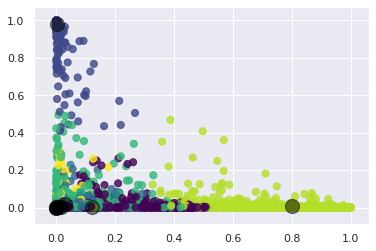

In [145]:
show_clusters(kmeans_autoencoder24, Y_val_ae_24_pred)

###### Latent vector size of 84

In [0]:
kmeans_autoencoder84 = KMeans(n_clusters=10).fit(Y_val_ae_84_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7563733723726996
Right: 61
Wrong: 11939


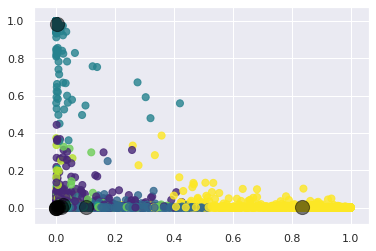

In [147]:
show_clusters(kmeans_autoencoder84, Y_val_ae_84_pred)

#### PCA

##### 80% variance

In [0]:
kmeans_pca_80var = KMeans(n_clusters=10).fit(Y_val_80var_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7524323879977292
Right: 1238
Wrong: 10762


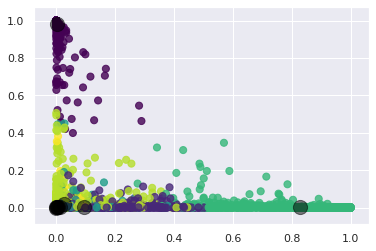

In [149]:
show_clusters(kmeans_pca_80var, Y_val_80var_pred)

##### 90% variance

In [0]:
kmeans_pca_90var = KMeans(n_clusters=10).fit(Y_val_90var_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7768901685559867
Right: 1152
Wrong: 10848


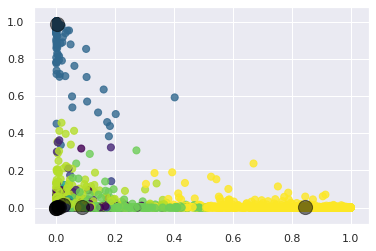

In [151]:
show_clusters(kmeans_pca_90var, Y_val_90var_pred)

##### 99% variance

In [0]:
kmeans_pca_99var = KMeans(n_clusters=10).fit(Y_val_99var_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7654385764656859
Right: 1857
Wrong: 10143


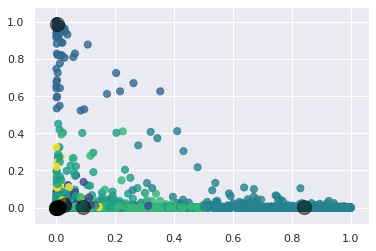

In [153]:
show_clusters(kmeans_pca_99var, Y_val_99var_pred)

### DBSCAN

#### Autoencoders

In [0]:
eps_dbscan = 100000
min_samples_dbscan = 1000

##### Latent vector size of 24

In [0]:
dbscan_autoencoder24 = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan).fit(Y_val_ae_24_pred)

Clusters: {0}
0.0
Right: 1228
Wrong: 10772


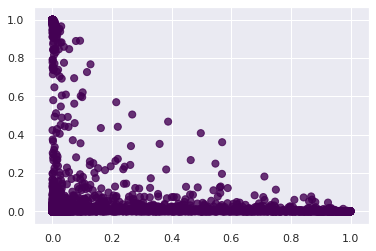

In [156]:
show_clusters(dbscan_autoencoder24, Y_val_ae_24_pred)

##### Latent vector size of 84

In [0]:
dbscan_autoencoder84 = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan).fit(Y_val_ae_84_pred)

Clusters: {0}
0.0
Right: 1228
Wrong: 10772


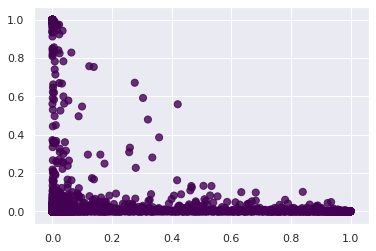

In [158]:
show_clusters(dbscan_autoencoder84, Y_val_ae_84_pred)

#### PCA

##### 80% variance

In [0]:
dbscan_pca_80var = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan).fit(Y_val_80var_pred)

Clusters: {0}
0.0
Right: 1228
Wrong: 10772


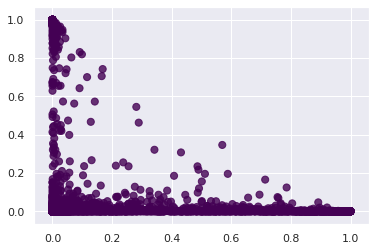

In [160]:
show_clusters(dbscan_pca_80var, Y_val_80var_pred)

##### 90% variance

In [0]:
dbscan_pca_90var = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan).fit(Y_val_90var_pred)

Clusters: {0}
0.0
Right: 1228
Wrong: 10772


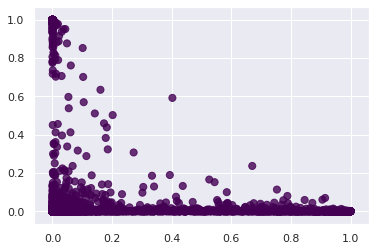

In [162]:
show_clusters(dbscan_pca_90var, Y_val_90var_pred)

##### 99% variance

In [0]:
dbscan_pca_99var = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan).fit(Y_val_99var_pred)

Clusters: {0}
0.0
Right: 1228
Wrong: 10772


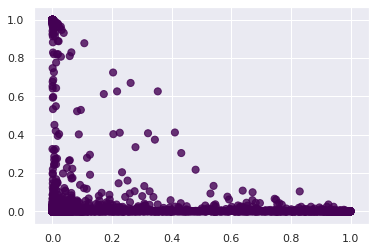

In [164]:
show_clusters(dbscan_pca_99var, Y_val_99var_pred)

### Spectral Clustering

#### Autoencoders

###### Latent vector size of 24

In [0]:
spectral_autoencoder24 = KMeans(n_clusters=10).fit(Y_val_ae_24_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7232419606766805
Right: 2485
Wrong: 9515


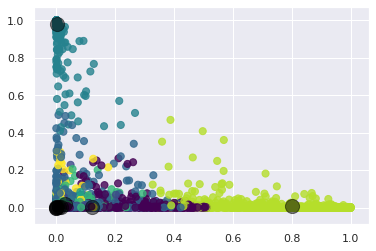

In [166]:
show_clusters(spectral_autoencoder24, Y_val_ae_24_pred)

###### Latent vector size of 84

In [0]:
spectral_autoencoder84 = KMeans(n_clusters=10).fit(Y_val_ae_84_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7232419606766805
Right: 2485
Wrong: 9515


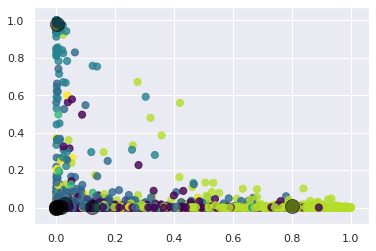

In [168]:
show_clusters(spectral_autoencoder24, Y_val_ae_84_pred)

#### PCA

##### 80% variance

In [0]:
spectral_pca_80var = KMeans(n_clusters=10).fit(Y_val_80var_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7524323879977292
Right: 4255
Wrong: 7745


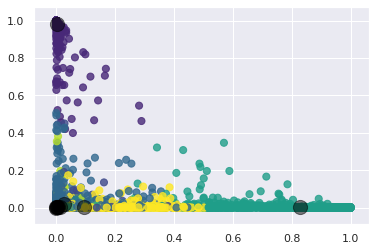

In [170]:
show_clusters(spectral_pca_80var, Y_val_80var_pred)

##### 90% variance

In [0]:
spectral_pca_90var = KMeans(n_clusters=10).fit(Y_val_90var_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7768901685559867
Right: 1368
Wrong: 10632


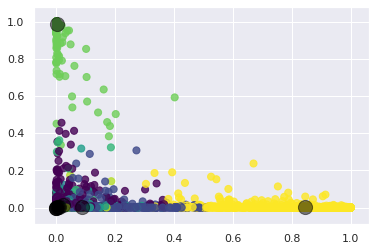

In [172]:
show_clusters(spectral_pca_90var, Y_val_90var_pred)

##### 99% variance

In [0]:
spectral_pca_99var = KMeans(n_clusters=10).fit(Y_val_99var_pred)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.7654385764656859
Right: 1252
Wrong: 10748


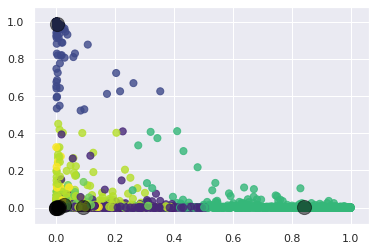

In [174]:
show_clusters(spectral_pca_99var, Y_val_99var_pred)

In [175]:
strftime('%X')

'13:19:13'